In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# create some dummy data (ANNs can fit to random noise very well!)
#TODO: changes this dummy data to a proper dataset with fined preprocessing

# dataset size: 1024; sequence length: 28; features: 10
x_train = np.random.normal(size=(1024, 28, 10))
# target: 0 or 1, randomly assigned
y_train = np.random.randint(low=0, high=2, size=(1024,1))
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

x_val = np.random.normal(size=(512, 28, 10))
# target: 0 or 1, randomly assigned
y_val = np.random.randint(low=0, high=2, size=(512,1))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(512).prefetch(tf.data.AUTOTUNE)


In [3]:
class RNNCell(tf.keras.layers.AbstractRNNCell):
    def __init__(self, units, **kwargs):
        self.units = units
        super(RNNCell, self).__init__(**kwargs)

        self.linear = tf.keras.layers.Dense(units)

        # layer normalization for trainability
        self.layer_norm = tf.keras.layers.LayerNormalization()

        # first recurrent layer in the RNN
        self.recurrent_layer = tf.keras.layers.Dense(units,
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation=tf.nn.tanh)
    @property
    def state_size(self):
        return [tf.TensorShape([self.units])]

    @property
    def output_size(self):
        return [tf.TensorShape([self.units])]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([self.units])]

    def call(self, inputs, states):
        prev_output = states[0]
        
        # linearly project input
        x = self.linear(inputs) + prev_output

        # apply first recurrent kernel
        new_state_layer = self.recurrent_layer(x)

        # apply layer norm
        x = self.layer_norm(new_state_layer)

        # return output and the list of new states of the layers
        return x, [new_state_layer]

    def get_config(self):
        return {"recurrent_units": self.units}

In [4]:
import tensorflow as tf

class LSTMCell(tf.keras.layers.AbstractRNNCell):
    
    def __init__(self, input_length=10, hidden_length=20):
        super(LSTMCell, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length

        # forget gate components
        self.linear_forget_w1 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_forget_r1 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # input gate components
        self.linear_gate_w2 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r2 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # cell memory components
        self.linear_gate_w3 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r3 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # out gate components
        self.linear_gate_w4 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r4 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        self.tanh = tf.keras.layers.Activation('tanh')

    @property
    def state_size(self):
        return (self.hidden_length, self.hidden_length)

    def call(self, inputs, states):
        h, c = states

        # forget gate
        f = self.sigmoid(self.linear_forget_w1(inputs) + self.linear_forget_r1(h))

        # input gate
        i = self.sigmoid(self.linear_gate_w2(inputs) + self.linear_gate_r2(h))

        # cell memory
        g = self.tanh(self.linear_gate_w3(inputs) + self.linear_gate_r3(h))
        c_next = f * c + i * g

        # output gate
        o = self.sigmoid(self.linear_gate_w4(inputs) + self.linear_gate_r4(h))

        # next hidden state
        h_next = o * self.tanh(c_next)

        return h_next, [h_next, c_next]


In [5]:
class RNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        '''
        self.rnn_cell = RNNCell(recurrent_units_1=24,
                                recurrent_units_2=48)
        ''' 
        self.rnn_cell = LSTMCell(input_length=10, hidden_length=24)

        # return_sequences collects and returns the output of the rnn_cell for all time-steps
        # unroll unrolls the network for speed (at the cost of memory)
        self.rnn_layer = tf.keras.layers.RNN(self.rnn_cell, return_sequences=False, unroll=True)

        self.output_layer = tf.keras.layers.Dense(1, activation="sigmoid")

        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.BinaryAccuracy()]

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def call(self, sequence, training=False):

        rnn_output = self.rnn_layer(sequence)

        return self.output_layer(rnn_output)

    def train_step(self, data):

        """
        Standard train_step method, assuming we use model.compile(optimizer, loss, ...)
        """

        sequence, label = data
        with tf.GradientTape() as tape:
            output = self(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name : m.result() for m in self.metrics}

    def test_step(self, data):

        """
        Standard test_step method, assuming we use model.compile(optimizer, loss, ...)
        """

        sequence, label = data
        output = self(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name : m.result() for m in self.metrics}

In [6]:
model = RNNModel()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
loss = tf.keras.losses.BinaryCrossentropy()

# compile the model (here, adding a loss function and an optimizer)
model.compile(optimizer = optimizer, loss=loss)

In [7]:
EXPERIMENT_NAME = "RNN_noise"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [8]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    initial_epoch=0,
                    epochs=50,
                    callbacks=[logging_callback])

Epoch 1/50


2024-03-16 10:50:23.135532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1024,1]
	 [[{{node Placeholder/_1}}]]
2024-03-16 10:50:23.135636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1024,1]
	 [[{{node Placeholder/_1}}]]
2024-03-16 10:50:24.417266: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/32 [===================>..........] - ETA: 0s - loss: 0.7007 - binary_accuracy: 0.5000 

2024-03-16 10:50:24.960821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [512,1]
	 [[{{node Placeholder/_1}}]]


32/32 [==============================] - 2s 12ms/step - loss: 0.6998 - binary_accuracy: 0.4980 - val_loss: 0.6987 - val_binary_accuracy: 0.4863
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6951 - binary_accuracy: 0.5146 - val_loss: 0.6985 - val_binary_accuracy: 0.4531
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6914 - binary_accuracy: 0.5283 - val_loss: 0.6977 - val_binary_accuracy: 0.4629
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6883 - binary_accuracy: 0.5420 - val_loss: 0.6975 - val_binary_accuracy: 0.4824
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6855 - binary_accuracy: 0.5576 - val_loss: 0.6982 - val_binary_accuracy: 0.4805
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6830 - binary_accuracy: 0.5645 - val_loss: 0.6976 - val_binary_accuracy: 0.4805
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6804 - binar

In [9]:
# save the complete model (incl. optimizer state, loss function, metrics etc.)
# ideally save to google drive if you're using colab
model.save("saved_model")

2024-03-16 10:50:28.642717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,28,10]
	 [[{{node input_1}}]]
2024-03-16 10:50:28.670536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,28,10]
	 [[{{node input_1}}]]
2024-03-16 10:50:28.677561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequence' with dtype float and shape [?,28,10]
	 [[{{node sequence}}]]
20

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


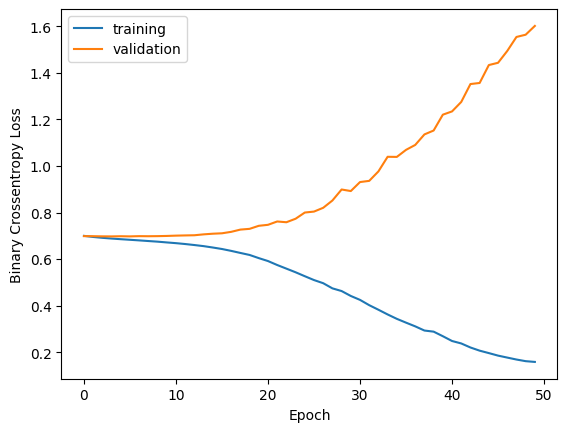

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels=["training","validation"])
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy Loss")
plt.show()

In [11]:
%load_ext tensorboard

In [12]:
%tensorboard --logdir="logs/RNN_noise"

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.